In [1]:
import os
from IPython.display import Image, display
from dotenv import load_dotenv
import gradio as gr

from typing import Annotated, TypedDict
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

/Users/duyanhle/Desktop/Project/1.in-progress/rag/learn-agentic-ai/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

True

### Define some tools (Out of the box and Custom)

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.tools import Tool

serper = GoogleSerperAPIWrapper()

tool_search = Tool(
    name='search',
    func=serper.run,
    description='Useful for when you need more informatuon from an online search'
)

tool_search.invoke('What is the population of France?')

'68.29 million (2023)'

In [5]:
import sendgrid
from sendgrid.helpers.mail import Mail, Email, To, Content

def send_email(body: str):
    '''Send email with the given body to all sales prospects using SendGrid API'''
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email('anh.leduy04@hcmut.edu.vn') # Verified sender
    to_email = To('duyanhlucas302@gmail.com') # To recipient
    subject = 'Test email'
    content = Content('text/plain', body)
    mail = Mail(from_email, to_email, subject, content).get()
    response = sg.client.mail.send.post(request_body=mail)
    return {'status': 'success'}

# Define tool
tool_push = Tool(
    name='send_email_tool',
    func=send_email,
    description='Useful for when you need to send an email to all sales prospects using SendGrid API'
)

tool_push.invoke('Test')

{'status': 'success'}

In [6]:
tools = [tool_search, tool_push]

### Graph

One small change - using TypedDict instead of BaseModel

In [7]:
# Step 1: Define State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [8]:
# Step 2: Start the graph builder with this State class
graph_builder = StateGraph(State)

When we implement tools, we always need to make 2 changes to the code:
1. Change to provide the tools to OpenAI in json when we make the call
2. Change to handle the results back: look for the model staying that the finish_reason == "tool_calls" and retrieve the call, run the function and provide the results

In [9]:
# Different:
llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools) # 1. When call this version, it will provide all tools to OpenAI in json

In [10]:
# Step 3: Create the node

def chatbot(state: State):
    return {
        "messages": [
            llm_with_tools.invoke(state['messages']) # handle request to the LLM and package up the tools in JSON format
        ]
    }

graph_builder.add_node("chatbot", chatbot)
# 2. Tool node: Handle when if any message wants to call any of the tools, it will call that tool
graph_builder.add_node("tools", ToolNode(tools=tools))

In [11]:
# Step 4: Create edges

# Connect "chatbot" node to "tools" node (node run actual tools) using condition edge
# we only want to call thost tools if the model returns a response that finish_reason==="tool_calls"
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")

# Important: create an edge from "tool" back to "chatbot"
# because the result from "tools" must be returned to "chatbot", to decide the next step 
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

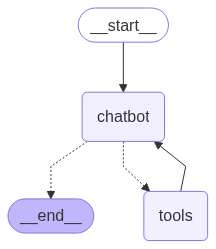

In [12]:
# Step 5: Compile graph
graph = graph_builder.compile()

display(Image(
    graph.get_graph().draw_mermaid_png()
))

In [13]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


Check for Langsmith: https://smith.langchain.com/

### Memory

Wait... We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

This is a crucial point for understanding LangGraph

*A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.*

One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

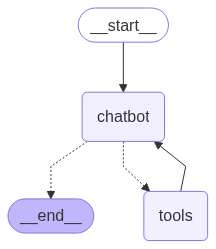

In [15]:
# Step 1 and 2
graph_builder = StateGraph(State)

# Step 3
llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools=tools)

def chatbot(state: State):
    print(State)
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory) # checkpoint is used to save the state of the graph
display(Image(
    graph.get_graph().draw_mermaid_png()
))

In [ ]:
config = {"configurable": {"thread_id": "1"}} # thread_id is used to identify the conversation

def chat(user_input: str, history):
    result = graph.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": user_input,
                }
            ]
        },
        config=config # make sure to pass the config to the graph to use correct slot of memory
    )
    print(result)
    return result["messages"][-1].content
    
gr.ChatInterface(chat, type='messages').launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


<class '__main__.State'>
{'messages': [HumanMessage(content='Hi, what is my name?', additional_kwargs={}, response_metadata={}, id='84fc0ee1-5720-432a-97c5-6e05b6462b55'), AIMessage(content="I'm sorry, but I don't have that information. If you'd like to share your name, I can remember it for our conversation!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 104, 'total_tokens': 131, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bf7SiX8OPBwgkbWpLSkAqemB9GxCn', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c2f851e6-502a-447f-aed9-66061ee1b6b7-0', usage_metadata={'input_tokens': 104, 'output_tokens': 27, 'total_tokens': 131, 'input_token_d

In [ ]:
# Change to another thread_id to see the difference
config = {"configurable": {"thread_id": "2"}}

def chat(user_input: str, history):
    result = graph.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": user_input,
                }
            ]
        },
        config=config # make sure to pass the config to the graph to use correct slot of memory
    )
    print(result)
    return result["messages"][-1].content
    
gr.ChatInterface(chat, type='messages').launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


<class '__main__.State'>
{'messages': [HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='bc2015ff-1885-4e43-8522-4c8da87c8506'), AIMessage(content="I don't have access to your personal information, including your name. If you'd like me to refer to you by a specific name or if there's something else you'd like to share, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 102, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bf7TILukx4ESZSwBNtpT2errQuGLH', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d6596c5c-5f62-488c-b444-9e7eb776d2c8-0', usage_metadata={'i

In [19]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='bc2015ff-1885-4e43-8522-4c8da87c8506'), AIMessage(content="I don't have access to your personal information, including your name. If you'd like me to refer to you by a specific name or if there's something else you'd like to share, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 102, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bf7TILukx4ESZSwBNtpT2errQuGLH', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d6596c5c-5f62-488c-b444-9e7eb776d2c8-0', usage_metadata={'input

In [20]:
# every super step (every time invoke the graph) the complete snapshot of the graph
# starting from the most recent to the top and going back in time

list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='bc2015ff-1885-4e43-8522-4c8da87c8506'), AIMessage(content="I don't have access to your personal information, including your name. If you'd like me to refer to you by a specific name or if there's something else you'd like to share, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 102, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bf7TILukx4ESZSwBNtpT2errQuGLH', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d6596c5c-5f62-488c-b444-9e7eb776d2c8-0', usage_metadata={'inpu

### Time Travel

Langchain allows to step back in time to any prior moment, which allows to build stable systems that can be recovered and rerun from any prior checkpoint.

```json
config = {
    "configurable": {
        "thread_id": 1,
        "checkpoint_id": ...
    }
}
```

#### Store memory in SQL Datbase

In [26]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver # pip install langgraph-checkpoint-sqlite

db_path = './db/memory.db'
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

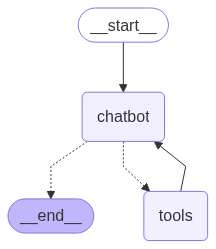

In [27]:
# Step 1 and 2
graph_builder = StateGraph(State)

# Step 3
llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools=tools)

def chatbot(state: State):
    print(State)
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory) # use sql memory as checkpointer
display(Image(
    graph.get_graph().draw_mermaid_png()
))

In [ ]:
config = {"configurable": {"thread_id": "1"}}
def chat(user_input: str, history):
    result = graph.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": user_input,
                }
            ]
        },
        config=config # make sure to pass the config to the graph to use correct slot of memory
    )
    print(result)
    return result["messages"][-1].content
    
gr.ChatInterface(chat, type='messages').launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


<class '__main__.State'>
{'messages': [HumanMessage(content='Hi, what is my name?', additional_kwargs={}, response_metadata={}, id='92b85074-4d95-4874-b175-640cdd3b8446'), AIMessage(content="I don't have access to your personal information, including your name. You can tell me your name if you'd like!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 104, 'total_tokens': 128, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bf7X1rf8JlGbLEtAlwTvz1g2Bqvx3', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3583b4dc-c27e-419d-bd4d-9c64f9ab0ee4-0', usage_metadata={'input_tokens': 104, 'output_tokens': 24, 'total_tokens': 128, 'input_token_details':

In [ ]:
config = {"configurable": {"thread_id": "2"}}
def chat(user_input: str, history):
    result = graph.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": user_input,
                }
            ]
        },
        config=config # make sure to pass the config to the graph to use correct slot of memory
    )
    print(result)
    return result["messages"][-1].content
    
gr.ChatInterface(chat, type='messages').launch()

* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


<class '__main__.State'>
{'messages': [HumanMessage(content='what is my name', additional_kwargs={}, response_metadata={}, id='b45e3616-1afd-454a-aedf-b83df4654f5d'), AIMessage(content="I don't have access to personal information like your name. If you'd like to share your name or if there's something else you need, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 101, 'total_tokens': 135, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bf7XhDY0itHOnkdDGDvxZKYl6vozC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b00ffade-4053-4a89-90f1-7892eeeda729-0', usage_metadata={'input_tokens': 101, 'output_tokens': 34, 't